In [1]:
import numpy as np
import random
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,initializers,constraints
import time
import math
import subprocess
import string
from nltk.corpus import words
import dgl
import matplotlib.pyplot as plt
import gensim
from statistics import mean
import networkx as nx
from tqdm.auto import tqdm

In [2]:
stopwords_file = open('Features/stopwords.txt','r')
stopwords = stopwords_file.read().split('\n')

In [3]:
# word2vec embedding
from gensim.models import KeyedVectors
# Load vectors directly from the file
word2vec = KeyedVectors.load_word2vec_format('Features/GoogleNews-vectors-negative300.bin', binary=True)
# word2vec['word'] to get the 300 dim word embedding

In [4]:
def get_portion_missing_word2vec():
    for i in range(train_query_df.shape[0]):
        c=0
        for w in train_doc_dict[train_query_df.iloc[i]['index']]['word'].values:
            if w not in word2vec.key_to_index.keys():
                c+=1
        print("{} ----------  {}/{}".format(c*100/train_doc_dict[train_query_df.iloc[i]['index']].shape[0],c,train_doc_dict[train_query_df.iloc[i]['index']].shape[0]))

In [5]:
def ret_query_doc(index,column_names):
    quer_doc_loc = 'Features/feature/{}.txt'.format(index)
    query_doc=pd.read_csv(quer_doc_loc, sep=" ", skiprows=1,names=column_names) # only place where num_of_docs is required
    query_doc[column_names[1:]]=query_doc[column_names[1:]].fillna(query_doc.mode().iloc[0])
    query_doc=query_doc.replace('-∞',0)
    query_doc[column_names[1:]]=query_doc[column_names[1:]].astype(float)
    query_doc = query_doc[~query_doc['word'].isin(stopwords)]
    query_doc = query_doc[query_doc['word'].isin(words.words())]
    
    # to be done for word2vec model
    query_doc = query_doc[query_doc['word'].isin(word2vec.key_to_index.keys())]
    
    query_doc.reset_index(inplace=True)
    query_doc = query_doc.drop('index', axis=1)
    return query_doc

In [6]:
def visualize_graph(g):
    nx_G = g.to_networkx()
    # Kamada-Kawaii layout usually looks pretty for arbitrary graphs
    pos = nx.kamada_kawai_layout(nx_G)
    nx.draw(nx_G, pos, with_labels=True, node_color=[[.7, .7, .7]])

In [7]:
def word_emb_fn(word, query_ser, query_term):
    global word2vec
    global num_of_docs
    emb = word2vec[word]
    quer_list = query_term.split(' ')
    sim_query=sum([word2vec.similarity(word, w) for w in quer_list if w in word2vec.key_to_index.keys()])
    siz = len([w for w in quer_list if w in word2vec.key_to_index.keys()])
    sim_query = sim_query/(siz if siz>0 else 1)
    doc_freq = query_ser['df']
    term_freq = mean([query_ser['tf{}'.format(i+1)] for i in range(num_of_docs)])
    inv_freq = query_ser['idf']
    word_emb = np.append(emb,np.array([sim_query,doc_freq,term_freq,inv_freq]))
    return tf.convert_to_tensor(word_emb, dtype=tf.float32)

In [8]:
# decide on the threshold for filtering edges
# hyperparameter
thresh_edges = 0.75

num_of_docs=10 # change this if number of documents retrieved by a query changes
num_of_features=4
agg_dim=int(np.sqrt(num_of_features)) # Hyperparameter

# data preprocessing for query file
quer_df_loc = 'Features/678-topics.txt' 
query_df=pd.read_csv(quer_df_loc,sep='=>',names=['index','query'], engine='python') 
column_names=['word']
column_names=column_names+['tf{}'.format(i) for i in range(1,num_of_docs+1)]
column_names=column_names+['idf']
column_names=column_names+['dl{}'.format(i) for i in range(1,num_of_docs+1)]
column_names=column_names+['df']

# to remove the retrieved docs which are wrongly structured
query_df = query_df[(query_df['index']!=312) & (query_df['index']!=348) & (query_df['index']!=424)]


# list of dataframes for the vocab and feature of each word in a given query
ret_docs=[ret_query_doc(index,column_names) for index in query_df['index'].values ]
query_doc_dict={query_df.iloc[i]['index']:ret_docs[i] for i in range(len(ret_docs))}

In [52]:
query_doc_dict[301].shape[0]

1587

In [40]:
def build_graph(query_term, query_doc): # This function is specific to the condition when low similarity edges are pruned
    global thresh_edges
    src_node = [k for j in [[i]*(query_doc.shape[0]) for i in range(query_doc.shape[0])] for k in j]
    dest_node = [i for i in range(query_doc.shape[0])]*query_doc.shape[0]
    
    node_emb = tf.convert_to_tensor([word_emb_fn(query_doc.iloc[i]['word'], 
                                                  query_doc.iloc[i], 
                                                  query_term) for i in range(query_doc.shape[0])], dtype=tf.float32)
    valid_edges = [(i,j) for i,j in tqdm(zip(src_node, dest_node)) if -tf.keras.losses.cosine_similarity(node_emb[i], node_emb[j]).numpy() >= thresh_edges]
                   #tf.reduce_sum(tf.multiply(tf.nn.l2_normalize(node_emb[i]), 
                    #                                                  tf.nn.l2_normalize(node_emb[j]))).numpy() >= thresh_edges]
    # valid_edges is a list of tuples (src_node, dest_node)
    new_src_node, new_dest_node = zip(*valid_edges)
    g = dgl.graph((new_src_node, new_dest_node), num_nodes=query_doc.shape[0])
    g.ndata['word'] = tf.convert_to_tensor(query_doc['word'].values)
    #edge_weights = tf.convert_to_tensor([tf.keras.losses.cosine_similarity(node_emb[i], node_emb[j]).numpy() for i,j in zip(src_node, dest_node)])
    #g.edata['weight'] = edge_weights
    #g = dgl.remove_self_loop(g)
    return (g, node_emb)

In [41]:
# query_graph_dict[i] returns the graph and feature vectors for query with index i
query_graph_dict = {query_df.iloc[i]['index']: build_graph(query_df.iloc[i]['query'], query_doc_dict[query_df.iloc[i]['index']]) 
                    for i in tqdm(range(query_df.shape[0]))}

  0%|          | 0/147 [00:00<?, ?it/s]

0it [00:00, ?it/s]

KeyboardInterrupt: 

In [42]:
g, node_emb = build_graph(query_df.iloc[0]['query'], query_doc_dict[301])

0it [00:00, ?it/s]

In [43]:
print(g)
print(g.ndata['word'])

Graph(num_nodes=1587, num_edges=802645,
      ndata_schemes={'word': Scheme(shape=(), dtype=tf.string)}
      edata_schemes={})
tf.Tensor([b'undermining' b'german' b'spoke' ... b'response' b'york' b'assured'], shape=(1587,), dtype=string)


In [52]:
[w.decode('utf-8') for w in g.ndata['word'].numpy()]

['undermining',
 'german',
 'spoke',
 'numerous',
 'salary',
 'basta',
 'kidnap',
 'persistent',
 'prison',
 'conceal',
 'successfully',
 'possess',
 'spreading',
 'competent',
 'require',
 'analysis',
 'apparent',
 'journalist',
 'size',
 'left',
 'seizing',
 'newspaper',
 'accessible',
 'role',
 'independent',
 'ahead',
 'achieve',
 'unparalleled',
 'talking',
 'example',
 'result',
 'gold',
 'feeding',
 'commission',
 'hand',
 'policy',
 'c',
 'committee',
 'address',
 'f',
 'namely',
 'h',
 'union',
 'k',
 'l',
 'm',
 'soviet',
 'p',
 'sale',
 'police',
 'v',
 'unprecedented',
 'fifth',
 'persistence',
 'days',
 'information',
 'returned',
 'adopted',
 'posing',
 'liberal',
 'standard',
 'acceptable',
 'powered',
 'unreasonably',
 'reader',
 'middleman',
 'serious',
 'export',
 'murder',
 'fantasy',
 'pay',
 'enormous',
 'onto',
 'gone',
 'governmental',
 'lack',
 'treasury',
 'success',
 'authority',
 'supposed',
 'categorically',
 'shocking',
 'regional',
 'applied',
 'provided',

In [ ]:
graph_list = [query_graph_dict[query_df.iloc[i]['index']] for i in range(query_df.shape[0])]

# train-test split
train_test_split_ratio = 0.9
train_graph_dict = {query_df.iloc[i]['index']: graph_list[i] 
                    for i in range(int(train_test_split_ratio*query_df.shape[0]))}
test_graph_dict = {query_df.iloc[i]['index']: graph_list[i] 
                    for i in range(int(query_df.shape[0]*train_test_split_ratio),query_df.shape[0])}

In [11]:
class GATLayer(keras.Model):
    def __init__(self,out_dim, negative_slope, activation, bias):
        super(GATLayer,self).__init__()
        self.fc = layers.Dense(out_dim,use_bias=bias)
        self.attn_fc = layers.Dense(1, use_bias=bias)
        self.actv_layer = layers.Activation(activation) if activation is not None else None
        self.negative_slope = negative_slope
        self.bias= bias
        
    def edge_attention(self,edges):
        z2 = tf.concat([edges.src['z'], edges.dst['z']], axis=1)
        a = self.attn_fc(z2)
        return {'e' : layers.LeakyReLU(alpha = self.negative_slope)(a)} # here alpha is a hyperparameter
    
    def message_func(self, edges):
        return {'z' : edges.src['z'], 'e' : edges.data['e']}
    
    def reduce_func(self, nodes):
        # reduce UDF for equation (3) & (4)
        # equation (3)
        alpha = keras.activations.softmax(nodes.mailbox['e'], axis=1)
        # equation (4)
        h = tf.math.reduce_sum(alpha * nodes.mailbox['z'], axis=1)
        h = self.actv_layer(h) if self.actv_layer is not None else h
        return {'h' : h}
    
    def call(self,g,h):
        self.g = g 
        z = self.fc(h)
        self.g.ndata['z'] = z
        self.g.apply_edges(self.edge_attention)
        self.g.update_all(self.message_func, self.reduce_func)
        return self.g.ndata.pop('h')

In [12]:
class MultiHeadGATLayer(keras.Model):
    def __init__(self, out_dim, num_heads, merge='cat', negative_slope = 0.3, activation = None, bias = False):
        super(MultiHeadGATLayer, self).__init__()
        self.heads = []
        for i in range(num_heads):
            self.heads.append(GATLayer(out_dim, negative_slope, activation, bias))
        self.merge = merge

    def call(self, g, h):
        self.g = g
        
        head_outs = [attn_head(g,h) for attn_head in self.heads]
        if self.merge == 'cat':
            # concat on the output feature dimension (dim=1)
            return tf.concat(head_outs, axis=1)
        else:
            # merge using average
            return tf.math.reduce_mean(tf.stack(head_outs), axis=0)

In [13]:
model = GATLayer(3, 0.3, None, False)
model(dgl.graph(([1,2,1,0],[0,1,3,2])), tf.constant([[1,2,3,4,6],[2,3,4,5,6],[3,4,5,6,7],[6,4,5,2,4]], dtype=tf.float32))

<tf.Tensor: shape=(4, 3), dtype=float32, numpy=
array([[-5.504841 ,  2.4977145, -3.627901 ],
       [-6.3327165,  3.2701852, -4.5804763],
       [-5.206317 ,  2.1945338, -2.7495675],
       [-5.504841 ,  2.4977145, -3.627901 ]], dtype=float32)>

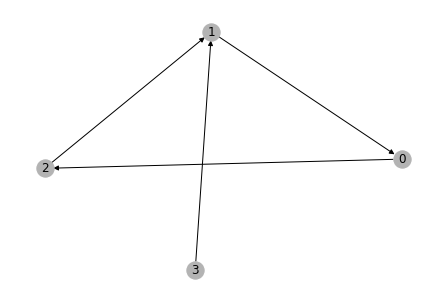

In [45]:
visualize_graph(dgl.graph(([1,2,3,0],[0,1,1,2])))

In [54]:
class Policy_Network(keras.Model):
    def __init__(self,
                 num_layers,
                 num_hidden,
                 num_classes,
                 heads,
                 activation = None,
                 feat_drop = None,
                 attn_drop = None,
                 negative_slope = 0.3,
                 merge = 'cat',
                 bias = False):
        super(Policy_Network, self).__init__()
        self.num_layers = num_layers
        self.gat_layers = []
        self.activation = activation
        # input projection (no residual)
        self.gat_layers.append(MultiHeadGATLayer(
            num_hidden, heads[0], merge,
            negative_slope, self.activation, bias))
        # hidden layers
        for l in range(1, num_layers):
            # due to multi-head, the in_dim = num_hidden * num_heads
            self.gat_layers.append(MultiHeadGATLayer(
                num_hidden, heads[l], merge,
                negative_slope, self.activation, bias))
        # output projection
        self.gat_layers.append(MultiHeadGATLayer(
            num_classes, heads[-1], merge,
            negative_slope, None, False))

    def call(self, g, inputs):
        self.g = g
        h = inputs
        for l in range(self.num_layers):
            h = self.gat_layers[l](self.g, h)
            h = tf.reshape(h, (h.shape[0], -1))
        # output projection
        logits = tf.reduce_mean(self.gat_layers[-1](self.g, h), axis=1)
        logits = keras.activations.softmax(tf.expand_dims(logits, axis=-1), axis=0)
        return logits

In [55]:
model = Policy_Network(3,3,2,[4,3,2])
(model(dgl.graph(([1,2,1,0],[0,1,3,2])), tf.constant([[1,2,3,4,5],[2,3,4,5,6],[3,4,5,6,7],[6,4,5,2,4]], dtype=tf.float32)))

<tf.Tensor: shape=(4, 1), dtype=float32, numpy=
array([[0.24788539],
       [0.20613079],
       [0.29809842],
       [0.24788539]], dtype=float32)>

In [58]:
# develop the above functions as class functions
class GAT_Implementation:
    
    def __init__(self,K):
        self.model=Policy_Network(num_layers = 3, # Hyperparameters of Policy Network
                             num_hidden = 4,
                             num_classes = 1,
                             heads = [4, 3, 2],
                             activation = None,
                             feat_drop = None,
                             attn_drop = None,
                             negative_slope = 0.3,
                             merge = 'cat',
                             bias = False)
        self.prev_eval=0.0
        self.K=K # number of samples extracted
    
    
    
    def prob_dist_query(self,F):  # ---> R(Q,F;C,Omega)   F has shape : (num_of_words,num_of_docs,num_of_features)
        R=self.model(F,training=True)
        R = tf.keras.activations.softmax(R,axis=0)
        return R # returns array of softmax p(w/Q) -- shape(num_of_words,1)
    
    def sampling_function(self,R): # shape of R : (number_of_words, 1)
        
        samples=tf.convert_to_tensor(np.random.choice(np.arange(len(self.vocabulary)),
                                                      size=(self.K,),replace=False,p=R[:,0].numpy()))
        #samples = tf.random.categorical(tf.math.log(tf.transpose(R).numpy()),self.K)[0]
        R_dash = tf.gather(params = R[:,0], indices = samples)
        R_dash=R_dash/tf.math.reduce_sum(R_dash)
        return samples,R_dash # returns (tensor,tensor)
    
    def sampling_test_function(self,R):
        samples = tf.math.top_k(R[:,0],k=self.K)
        R_dash = samples.values
        R_dash = R_dash/tf.math.reduce_sum(R_dash)
        return samples.indices,R_dash
        
    def prob_MLE_fn(self,q,samples):
        R_MLE=tf.convert_to_tensor([q.count(self.vocabulary[i]) for i in samples.numpy()],dtype=tf.float32)
        return R_MLE/len(q.split()) # returns tensor

    def interpolation_function(self,R_MLE,R_dash,alpha=0.5): # alpha is Hyperparamter (importance of word in the original query)
        R_cap=alpha*R_MLE+(1-alpha)*R_dash
        return R_cap # returns tensor   
    
    def retrieval(self, index, query, rf_query):
        filename = "query/query_ti"
        xml_file = open(filename, "w", encoding='utf8')
        n = xml_file.write(rf_query)
        xml_file.close()
    
        #running indri query
        indrirunquery_command =  '/home/ir-group/indri-5.12/runquery/IndriRunQuery'
        result = subprocess.Popen([indrirunquery_command, filename],
                                  stdout=subprocess.PIPE,
                                  stderr=subprocess.STDOUT)
        stdout, stderr = result.communicate()
        
        res_file = "query/query_rq"
        file1 = open(res_file, "wb")
        n1 = file1.write(stdout)
        file1.close()
        
        #performing TREC_eval
        indritrec_command =  '/home/ir-group/indri-5.12/trec_eval.9.0/trec_eval'
        trec_qrel = '/home/ir-group/indri-5.12/trec_eval.9.0/678_qrel'
        result1 = subprocess.Popen([indritrec_command, trec_qrel, res_file],
                                  stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
        stdout, stderr = result1.communicate()
        
        #saving MAP results
        map_file = "query/query_MAP"
        file2 = open(map_file, "wb")
        n2 = file2.write(stdout)
        file2.close()

        #returning the MAP result for a query
        file = open('query/query_MAP')
        content = file.readlines()
        #print(content)
        split_l = content[5].split("\t")
        print("MAP value: ", split_l[2])
        MAP = split_l[2]
        return MAP

    def query_reformulation(self, word_sample_dict, index, query):
        index_filepath = "/home/ir-group/indri-5.12/trec678.index/"
        preamble_string = "<parameters>\n<index>"+index_filepath+"</index>\n<runID>RML</runID>\n<trecFormat>true</trecFormat>\n<rule>method:dirichlet;mu:1500</rule>\n<count>10</count>\n<query>\n<number>" + str(index) + "</number>\n<text>"
        end_string = "</text>\n</query>\n</parameters>"
        expansion = ""
        ifac = 0.75
        table = str.maketrans(dict.fromkeys(string.punctuation))
        for key, value in word_sample_dict.items():
#            print(key, "and", value)
            expansion = expansion + str(value) + " " + key + " "
            # Removing punctuations as Indri doesnt support these characters
            term = expansion.translate(table) #removing punctuations
            
        reformulation = "#weight( " + str(ifac) + " #combine(" + query + ") " + str(1-ifac) + " #combine( " + expansion + "))"
        reformulated_query = preamble_string + " " + reformulation + " " + end_string
        #print(reformulated_query)
        return reformulated_query
    
    def eval_fn(self, word_sample_dict, index, query): # takes input the dictionary of size self.K which maps the word with its weight
        
        rf_query = self.query_reformulation(word_sample_dict, index, query)
        MAP = self.retrieval(index, query, rf_query)
        #print("MAP form eval", MAP, " ", type(MAP))
        return tf.cast(float(MAP),dtype=tf.float32)
            
    def reward_fn(self,word_sample_dict, index, query):  # doubt regarding the eval(Q,t) - eval(Q,t-1), the use of prev_eval ??
        t=self.eval_fn(word_sample_dict, index, query)
        reward=t-self.prev_eval
        self.prev_eval=t
        return reward
    
    def cross_entropy_loss(self,R_dash,R,word_sample):
        #R_temp=tf.convert_to_tensor([np.log(R[:,0].numpy()[i]) for i in word_sample.numpy()],dtype=tf.float32)
        R_temp = tf.gather(params=tf.math.log(R[:,0]),indices = word_sample.numpy())
        return tf.math.reduce_sum([i[0]*i[1] for i in zip(R_dash,R_temp)])
    
    def compute_loss_fn(self,X_batch): # X_batch is the dataframe containing 'index' and 'query' column for a given batch_size
        L=tf.constant(0.,dtype=tf.float32)
        for i in range(X_batch.shape[0]):
            index=int(X_batch.iloc[i]['index'])
            query = str(X_batch.iloc[i]['query'])
            print('----------------- Running query {} : {} -----------------'.format(index, query))
            g, node_emb = self.query_graph_dict[index]
            self.vocabulary=np.array([w.decode('utf-8') for w in g.ndata['word'].numpy()])
            R = self.model(g, node_emb)
            word_sample,R_dash=self.sampling_function(R)
            R_MLE=self.prob_MLE_fn(query,word_sample)
            R_cap=self.interpolation_function(R_MLE,R_dash,alpha=0.6) 
            word_sample_dict = dict(zip([self.vocabulary[i] for i in word_sample],R_cap.numpy()))
            print("-> {}".format(word_sample_dict))
            L=L-self.reward_fn(word_sample_dict, index, query)*self.cross_entropy_loss(R_dash,R,word_sample)
        L = tf.convert_to_tensor(L,dtype=tf.float32)
        return L
    def train(self,query_df,query_graph_dict,epochs=10,batch_size=16):  # takes input as the queries and the documents retrieved by each query as a dict
        # query_df is the dataframe containing 'index' and 'query' column
        num_of_queries=query_df.shape[0] 
        self.query_graph_dict=query_graph_dict
        num_epochs=epochs
        optimizer=keras.optimizers.Adam(learning_rate = 0.001)
        for epoch in range(num_epochs):
            print('Start of training epoch : {}'.format(epoch))
            for i in tqdm(range(int(num_of_queries/batch_size))):     
                X_batch=query_df.iloc[i*batch_size:(i+1)*batch_size] # X_batch is a dataframe with 'index' and 'query' column
                with tf.GradientTape() as tape:
                    loss = self.compute_loss_fn(X_batch)
                    print("Loss for epoch={} and batch={} : {}".format(epoch,i+1,loss))   
                gradients=tape.gradient(loss,self.model.trainable_variables)
                optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))

                
            if num_of_queries%batch_size!=0:
                X_batch=query_df.iloc[int(num_of_queries/batch_size)*batch_size:]
                with tf.GradientTape() as tape:
                    loss=self.compute_loss_fn(X_batch)
                    print("Loss for epoch={} and batch=rem : {}".format(epoch,loss))   
                gradients=tape.gradient(loss,self.model.trainable_weights)
                optimizer.apply_gradients(zip(gradients,self.model.trainable_weights))
        
    def test(self,query_df,query_graph_dict):
        print('Testing the model : ')
        num_of_queries = query_df.shape[0]
        self.query_graph_dict = query_graph_dict
        map_arr = []
        for i in range(query_df.shape[0]):
            query = query_df.iloc[i]['query']
            index = query_df.iloc[i]['index']
            g, node_emb = self.query_graph_dict[index]
            self.vocabulary=np.array([w.decode('utf-8') for w in g.ndata['word'].numpy()])
            R = self.model(g, node_emb)
            word_sample, R_dash = self.sampling_test_function(R)
            R_MLE=self.prob_MLE_fn(query,word_sample)
            R_cap=self.interpolation_function(R_MLE,R_dash,alpha=0.6)
            word_sample_dict = dict(zip([self.vocabulary[i] for i in word_sample],R_cap.numpy()))
            print('query : {}'.format(query))
            print("Reformalised query terms -> {}".format(word_sample_dict))
            MAP = (self.eval_fn(word_sample_dict, index, query)).numpy()
            map_arr = map_arr + [MAP]
        return map_arr     

In [61]:
start=time.time()
gat=GAT_Implementation(4) # pass K : the number of samples to extract for query reformulation
#x = train_doc_dict[train_query_df.iloc[0]['index']]
#temp = rml.model(tf.random.uniform(shape=[x.shape[0],num_of_docs,num_of_features]),training=False)
#rml.model.load_weights('saved_weights.h5') # comment this statement to train the model from scratch
gat.train(query_df.iloc[:1],{301:(g, node_emb)},epochs = 2, batch_size = 1)
end=time.time()
print('time elapsed in training the model : {} hrs'.format((end-start)/3600))


Start of training epoch : 0


  0%|          | 0/1 [00:00<?, ?it/s]

----------------- Running query 301 : international organized crime -----------------
-> {'bigger': 0.10042323, 'optimism': 0.099876694, 'occupant': 0.09977258, 'maximum': 0.099927485}
MAP value:  0.0056

Loss for epoch=0 and batch=1 : 0.04133712127804756
Start of training epoch : 1


  0%|          | 0/1 [00:00<?, ?it/s]

----------------- Running query 301 : international organized crime -----------------
-> {'internecine': 0.09956037, 'ourselves': 0.09968721, 'substantially': 0.09961853, 'seven': 0.10113388}
MAP value:  0.0049

Loss for epoch=1 and batch=1 : -0.005160697735846043
time elapsed in training the model : 0.04540722330411275 hrs
